In [1]:
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

import pdb

# Read Data

In [2]:
g = open('reviews.txt','r') # What we know!
reviews = list(map(lambda x:x[:-1],g.readlines()))
g.close()

g = open('labels.txt','r') # What we WANT to know!
labels = list(map(lambda x:x[:-1].upper(),g.readlines()))
g.close()

# Explore Data

### Print Dist

In [3]:
print(labels[0], reviews[0])

POSITIVE bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   


In [4]:
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

# TODO: Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for rev, lab in zip(reviews, labels):
    for wr in rev.split():
        total_counts[wr] += 1
        if lab == 'POSITIVE':
            positive_counts[wr] += 1
        elif lab == 'NEGATIVE':
            negative_counts[wr] += 1
        else:
            raise ValueError()

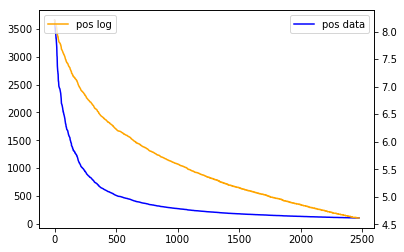

In [5]:
# Examine the counts of the most common words in positive reviews
#positive_counts.most_common()[0:1000]
fig = plt.figure()
ax = fig.add_subplot(111)
my_data = np.array(sorted(list(positive_counts.values()), reverse=True))
my_data = my_data[my_data > 100][100:]

ax.plot(my_data, color='blue', label='pos data')
ax.legend(loc=0)
ax2 = ax.twinx()
ax2.plot(np.log(my_data), color='orange', label='pos log')
ax2.legend(loc=2)

In [6]:
positive_counts.most_common()[:10]

[('the', 173324),
 ('.', 159654),
 ('and', 89722),
 ('a', 83688),
 ('of', 76855),
 ('to', 66746),
 ('is', 57245),
 ('in', 50215),
 ('br', 49235),
 ('it', 48025)]

### Print Ratios

In [7]:
pos_neg_ratios = Counter()
pos_neg_ratios_no_log = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio
        pos_neg_ratios_no_log[term] = pos_neg_ratio

In [8]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios["terrible"]))

Pos-to-neg ratio for 'the' = 1.0607993145235326
Pos-to-neg ratio for 'amazing' = 4.022813688212928
Pos-to-neg ratio for 'terrible' = 0.17744252873563218


In [9]:
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)

In [10]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'amazing' = {}".format(pos_neg_ratios["amazing"]))
print("Pos-to-neg ratio for 'terrible' = {}".format(pos_neg_ratios["terrible"]))

Pos-to-neg ratio for 'the' = 0.05902269426102881
Pos-to-neg ratio for 'amazing' = 1.3919815802404802
Pos-to-neg ratio for 'terrible' = -1.7291085042663878


In [11]:
# words most frequently seen in a review with a "POSITIVE" label
pos_neg_ratios.most_common()[:10]

[('edie', 4.6913478822291435),
 ('paulie', 4.07753744390572),
 ('felix', 3.152736022363656),
 ('polanski', 2.8233610476132043),
 ('matthau', 2.80672172860924),
 ('victoria', 2.681021528714291),
 ('mildred', 2.6026896854443837),
 ('gandhi', 2.538973871058276),
 ('flawless', 2.451005098112319),
 ('superbly', 2.26002547857525)]

''

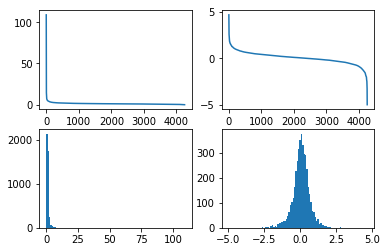

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
my_data_nl = np.array(sorted(list(pos_neg_ratios_no_log.values())[:], reverse=True))
my_data = np.array(sorted(list(pos_neg_ratios.values()), reverse=True))

ax1.plot(my_data_nl)
ax2.plot(my_data)
ax3.hist(my_data_nl, 100)
ax4.hist(my_data, 100)
;

# Convert Data

In [13]:
review_vocab = set(total_counts.keys())
review_vocab_size = len(review_vocab)
print(review_vocab_size)

74073


In [14]:
targets = np.zeros(shape=[len(labels)])
for idx, label in enumerate(labels):
    if label == 'POSITIVE': targets[idx] = 1
    elif label == 'NEGATIVE': targets[idx] = 0
    else: raise ValueError()

In [15]:
word2index = {}
for i,word in enumerate(review_vocab):
    word2index[word] = i

# Model

In [101]:
def review_to_vector(review, input_layer):
    input_layer *= 0
    for word in review.split():
        input_layer[0, word2index[word]] = 1  # don't count above 1!
        
def review_to_indices(review):
    res = []
    for word in review.split():
        if word in word2index:
            res.append(word2index[word])
    return np.unique(res)
        
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_deriv(x):
    return sigmoid(x) * (1-sigmoid(x))

def forward(xv, Wh, Wo):
    assert xv.ndim == 2
    z_hid = xv @ Wh
    # do not do hidden activation
    z_out = z_hid @ Wo
    y_hat = sigmoid(z_out)
    return y_hat, z_out, z_hid

def forward_idx(xi, Wh, Wo):
    assert xi.ndim == 1
    # OPTIMIZE: z_hid = xv @ Wh    
    z_hid = np.sum(Wh[xi], axis=0, keepdims=True)
    
#     xv = np.zeros([1, len(Wh)])
#     xv[0,xi] = 1
#     z_hid_2 = xv @ Wh
#     assert np.allclose(z_hid, z_hid_2)
    
    # do not do hidden activation
    z_out = z_hid @ Wo
    y_hat = sigmoid(z_out)
    return y_hat, z_out, z_hid

def backward(xv, y, Wh, Wo):
    assert xv.ndim == 2
    assert y.ndim == 2
    y_hat, z_out, z_hid = forward(xv, Wh, Wo)
    ro_out = (y-y_hat) * -sigmoid_deriv(z_out)  # scalar
    del_Wo = np.dot(z_hid.T, ro_out)            # hid_n x 1

    ro_hid = np.dot(ro_out, Wo.T)      # 1 x hid_n
    del_Wh = np.dot(xv.T, ro_hid)      # in_n x hid_n

    return del_Wo, del_Wh, y_hat

def backward_idx(xi, y, Wh, Wo, lr):
    assert xi.ndim == 1
    assert y.ndim == 2
    y_hat, z_out, z_hid = forward_idx(xi, Wh, Wo)
    ro_out = (y-y_hat) * -sigmoid_deriv(z_out)  # scalar
    del_Wo = np.dot(z_hid.T, ro_out)            # hid_n x 1
    
    ro_hid = np.dot(ro_out, Wo.T)      # 1 x hid_n
    
    # OPTIMIZE: del_Wh = np.dot(xv.T, ro_hid)
    Wh[xi] += -lr * ro_hid
    
#     del_Wh = np.zeros_like(Wh)
#     del_Wh[xi] = ro_hid
#     xv = np.zeros([1, len(Wh)])
#     xv[0,xi] = 1
#     del_Wh_2 = np.dot(xv.T, ro_hid)
#     if not np.allclose(del_Wh, del_Wh_2):
#         pdb.set_trace()
#     Wh += -lr * del_Wh
    
    return y_hat
    
def loss(xv, y, Wh, Wo):
    y_hat, z_out, z_hid = forward(xv, Wh, Wo)
    return .5 * np.mean((y-y_hat)**2)

def ngrad(xv, y, Wh, Wo):
    assert xv.ndim == 2
    assert y.ndim == 2
    
    eps = 1e-4
    
    # numerical gradient check output
    ngrad_Wo = np.zeros_like(Wo)
    for r in range(Wo.shape[0]):
        for c in range(Wo.shape[1]):
            W_min = Wo.copy()
            W_pls = Wo.copy()
            W_min[r, c] -= eps
            W_pls[r, c] += eps

            l_pls = loss(xv, y, Wh, W_pls)
            l_min = loss(xv, y, Wh, W_min)

            ngrad_Wo[r, c] = (l_pls - l_min) / (eps * 2)
    
    # numerical gradient check hidden
    ngrad_Wh = np.zeros_like(Wh)
    _, idx_nonzero = np.nonzero(xv)
    for r in idx_nonzero: #range(self.weights_0_1.shape[0]):
        for c in range(Wh.shape[1]):
            if r % 1000 == 0: print(r)
            W_min = Wh.copy()
            W_pls = Wh.copy()
            W_min[r, c] -= eps
            W_pls[r, c] += eps

            l_pls = loss(xv, y, W_pls, Wo)
            l_min = loss(xv, y, W_min, Wo)

            ngrad_Wh[r, c] = (l_pls - l_min) / (eps * 2)
            
    return ngrad_Wo, ngrad_Wh         


In [105]:
N_in = len(review_vocab)
N_hid = 10
N_out = 1
lr = 0.1

np.random.seed(1)

W_hid = np.zeros([N_in, N_hid])
# W_hid = np.random.normal(0, N_in**-.5, [N_in, N_hid])
W_out = np.random.normal(0, N_hid**-.5, [N_hid, N_out])
layer_0 = np.zeros([1, N_in])

In [19]:
print(labels[0], ':', targets[0])
print(labels[1], ':', targets[1])

POSITIVE : 1.0
NEGATIVE : 0.0


# Train Loop

In [103]:
import time
import sys

def test(testing_reviews, testing_targets, l0, Wh, Wo):
    
    # keep track of how many correct predictions we make
    correct = 0
    positive = 0

    # we'll time how many predictions per second we make
    start = time.time()

    # Loop through each of the given reviews and call run to predict
    # its label. 
    for i in range(len(testing_reviews)):
        
        review = testing_reviews[i].lower()
        review_to_vector(review, l0)
        
        #test
        indices = review_to_indices(review)
        l0_2 = np.zeros_like(l0)
        l0_2[indices] = 1
        assert np.alltrue(l0 == l0_2)
        
        y_hat, z_out, z_hid = forward(l0, Wh, Wo)
                
        pred = np.round(np.asscalar(y_hat))
        if(pred == testing_targets[i]):
            correct += 1
        if(pred):
            positive += 1

        # For debug purposes, print out our prediction accuracy and speed 
        # throughout the prediction process. 

        elapsed_time = float(time.time() - start)
        reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0

        sys.stdout.write("\rProgress:" + str(100 * i/float(len(testing_reviews)))[:4] \
                         + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                         + " #Positive: " + str(positive) \
                         + " #Correct:" + str(correct) + " #Tested:" + str(i+1) \
                         + " Testing Accuracy:" + str(correct * 100 / float(i+1))[:4] + "%")
        
def train(training_reviews, training_targets, l0, Wh, Wo, lr, optimize=False):
    assert(len(training_reviews) == len(training_targets))
    
    # Keep track of correct predictions to display accuracy during training 
    correct_so_far = 0
    
    # Precompute for optimization
    training_reviews_indices = []
    for review in training_reviews:
        training_reviews_indices.append(review_to_indices(review))

    # Remember when we started for printing time statistics
    start = time.time()

    # loop through all the given reviews and run a forward and backward pass,
    # updating weights for every item
    for i in range(len(training_reviews)):

        # TODO: Get the next review and its correct label
        review = training_reviews[i]  # str
        y = np.array([[training_targets[i]]])   # scalar

        if optimize:
            xi = training_reviews_indices[i]
            y_hat = backward_idx(xi, y, Wh, Wo, lr)
        
        else:
            review_to_vector(review, l0)
            del_Wo, del_Wh, y_hat = backward(l0, y, Wh, Wo)
            y_hat = np.asscalar(y_hat)

    #         # Numerical gradient check
    #         ngrad_Wo, ngrad_Wh = ngrad(l0, y, Wh, Wo)
    #         if not np.allclose(del_Wo, ngrad_Wo):
    #             raise ValueError('Gradient check fail output')
    #         if not np.allclose(del_Wh, ngrad_Wh):
    #             raise ValueError('Gradient check fail hidden')
    #         print('ngrad OK')

            Wh += -lr * del_Wh
            Wo += -lr * del_Wo
        
        if np.abs(y-y_hat) < 0.5:
            correct_so_far += 1
            
        elapsed_time = float(time.time() - start)
        reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0

        if(i % 2500 == 0):
            sys.stdout.write("\rProgress:" + str(100 * i/float(len(training_reviews)))[:4] \
                         + "% Speed(reviews/sec):" + str(reviews_per_second)[0:5] \
                         + " #Correct:" + str(correct_so_far) + " #Trained:" + str(i+1) \
                         + " Training Accuracy:" + str(correct_so_far * 100 / float(i+1))[:4] + "%")
        
            print("")

In [67]:
test(reviews[-1000:], targets[-1000:], layer_0, W_hid, W_out)

Progress:13.0% Speed(reviews/sec):633.2 #Positive: 0 #Correct:65 #Tested:131 Testing Accuracy:49.6%

Progress:22.8% Speed(reviews/sec):558.2 #Positive: 0 #Correct:114 #Tested:229 Testing Accuracy:49.7%

Progress:35.4% Speed(reviews/sec):579.0 #Positive: 0 #Correct:177 #Tested:355 Testing Accuracy:49.8%

Progress:49.0% Speed(reviews/sec):601.6 #Positive: 0 #Correct:245 #Tested:491 Testing Accuracy:49.8%

Progress:64.6% Speed(reviews/sec):625.3 #Positive: 0 #Correct:323 #Tested:647 Testing Accuracy:49.9%

Progress:78.5% Speed(reviews/sec):631.1 #Positive: 0 #Correct:393 #Tested:786 Testing Accuracy:50.0%

Progress:94.9% Speed(reviews/sec):647.7 #Positive: 0 #Correct:475 #Tested:950 Testing Accuracy:50.0%

Progress:99.9% Speed(reviews/sec):640.9 #Positive: 0 #Correct:500 #Tested:1000 Testing Accuracy:50.0%

In [115]:
train(reviews[:-1000], targets[:-1000], layer_0, W_hid, W_out, lr)

Progress:0.0% Speed(reviews/sec):0.0 #Correct:0 #Trained:1 Training Accuracy:0.0%
Progress:10.4% Speed(reviews/sec):70.05 #Correct:1390 #Trained:2501 Training Accuracy:55.5%
Progress:20.8% Speed(reviews/sec):70.96 #Correct:3094 #Trained:5001 Training Accuracy:61.8%
Progress:31.2% Speed(reviews/sec):70.11 #Correct:4932 #Trained:7501 Training Accuracy:65.7%
Progress:41.6% Speed(reviews/sec):70.09 #Correct:6858 #Trained:10001 Training Accuracy:68.5%
Progress:52.0% Speed(reviews/sec):70.04 #Correct:8812 #Trained:12501 Training Accuracy:70.4%
Progress:62.5% Speed(reviews/sec):77.27 #Correct:10764 #Trained:15001 Training Accuracy:71.7%
Progress:72.9% Speed(reviews/sec):83.34 #Correct:12675 #Trained:17501 Training Accuracy:72.4%
Progress:83.3% Speed(reviews/sec):88.11 #Correct:14677 #Trained:20001 Training Accuracy:73.3%
Progress:93.7% Speed(reviews/sec):92.62 #Correct:16707 #Trained:22501 Training Accuracy:74.2%
Progress:99.9% Speed(reviews/sec):95.08 #Correct:17952 #Trained:24000 Training A

In [48]:
train(reviews[:-1000], targets[:-1000], layer_0, W_hid, W_out, lr)

Progress:0.0% Speed(reviews/sec):0.0 #Correct:0 #Trained:1 Training Accuracy:0.0%
Progress:10.4% Speed(reviews/sec):156.0 #Correct:1958 #Trained:2501 Training Accuracy:78.2%
Progress:20.8% Speed(reviews/sec):158.3 #Correct:4002 #Trained:5001 Training Accuracy:80.0%
Progress:31.2% Speed(reviews/sec):159.4 #Correct:6131 #Trained:7501 Training Accuracy:81.7%
Progress:41.6% Speed(reviews/sec):159.6 #Correct:8288 #Trained:10001 Training Accuracy:82.8%
Progress:52.0% Speed(reviews/sec):159.6 #Correct:10447 #Trained:12501 Training Accuracy:83.5%
Progress:62.5% Speed(reviews/sec):160.1 #Correct:12588 #Trained:15001 Training Accuracy:83.9%
Progress:72.9% Speed(reviews/sec):160.2 #Correct:14703 #Trained:17501 Training Accuracy:84.0%
Progress:83.3% Speed(reviews/sec):159.4 #Correct:16876 #Trained:20001 Training Accuracy:84.3%
Progress:93.7% Speed(reviews/sec):159.4 #Correct:19062 #Trained:22501 Training Accuracy:84.7%
Progress:99.9% Speed(reviews/sec):159.4 #Correct:20380 #Trained:24000 Training 

In [100]:
train(reviews[:-1000], targets[:-1000], layer_0, W_hid, W_out, lr, optimize=True)

Progress:0.0% Speed(reviews/sec):0.0 #Correct:0 #Trained:1 Training Accuracy:0.0%
Progress:10.4% Speed(reviews/sec):62.60 #Correct:1965 #Trained:2501 Training Accuracy:78.5%
Progress:20.8% Speed(reviews/sec):59.89 #Correct:4009 #Trained:5001 Training Accuracy:80.1%
Progress:31.2% Speed(reviews/sec):57.74 #Correct:6131 #Trained:7501 Training Accuracy:81.7%
Progress:41.6% Speed(reviews/sec):55.94 #Correct:8283 #Trained:10001 Training Accuracy:82.8%
Progress:52.0% Speed(reviews/sec):57.58 #Correct:10443 #Trained:12501 Training Accuracy:83.5%
Progress:62.5% Speed(reviews/sec):58.56 #Correct:12578 #Trained:15001 Training Accuracy:83.8%
Progress:72.9% Speed(reviews/sec):59.39 #Correct:14683 #Trained:17501 Training Accuracy:83.8%
Progress:83.3% Speed(reviews/sec):60.08 #Correct:16846 #Trained:20001 Training Accuracy:84.2%
Progress:93.7% Speed(reviews/sec):60.30 #Correct:19024 #Trained:22501 Training Accuracy:84.5%


In [106]:
train(reviews[:-1000], targets[:-1000], layer_0, W_hid, W_out, lr, optimize=True) 

Progress:0.0% Speed(reviews/sec):0.0 #Correct:0 #Trained:1 Training Accuracy:0.0%
Progress:10.4% Speed(reviews/sec):9138. #Correct:1965 #Trained:2501 Training Accuracy:78.5%
Progress:20.8% Speed(reviews/sec):9137. #Correct:4009 #Trained:5001 Training Accuracy:80.1%
Progress:31.2% Speed(reviews/sec):9184. #Correct:6131 #Trained:7501 Training Accuracy:81.7%
Progress:41.6% Speed(reviews/sec):9225. #Correct:8283 #Trained:10001 Training Accuracy:82.8%
Progress:52.0% Speed(reviews/sec):9223. #Correct:10443 #Trained:12501 Training Accuracy:83.5%
Progress:62.5% Speed(reviews/sec):9245. #Correct:12578 #Trained:15001 Training Accuracy:83.8%
Progress:72.9% Speed(reviews/sec):9242. #Correct:14683 #Trained:17501 Training Accuracy:83.8%
Progress:83.3% Speed(reviews/sec):9204. #Correct:16846 #Trained:20001 Training Accuracy:84.2%
Progress:93.7% Speed(reviews/sec):9150. #Correct:19024 #Trained:22501 Training Accuracy:84.5%
